# Just a Practice Notebook for Random Data Science Stuff

In [1]:
import torch
from pprint import pprint

In [2]:
class Metrics():
    def euclidean_distance(self, X, Y):
        Z = X - Y
        return torch.sqrt(torch.dot(Z, Z))
         
    def manhattan_distance(self, X, Y):
        return torch.sum(torch.abs(X - Y))

    def cosine_similarity(self, X, Y):
        return torch.dot(X, Y) / (self.two_norm(X) * self.two_norm(Y))
        # or even simpler with: 
        # return torch.cosine_similarity(X, Y, dim=0) 

    def jaccard_similarity(self, X, Y):                
        XandY = set([e for e in X + Y])
        XorY = set([e for e in X if e in Y])
        return len(XorY) / len(XandY)
        
    def two_norm(self, X):
        return sum(xi ** 2 for xi in X) ** 0.5

X = torch.tensor([1, 3, 4, 5], dtype=torch.float32)
Y = torch.tensor([7, 6, 3, 1], dtype=torch.float32)

print("X={}".format(X))
print("Y={}".format(Y))

metrics = Metrics()
print("2-Norm of X: {}".format(metrics.two_norm(X)))
print("2-Norm of Y: {}".format(metrics.two_norm(Y)))
print()
print("Euclidean Distance: {}".format(metrics.euclidean_distance(X,Y)))
print("Manhattan Distance: {}".format(metrics.manhattan_distance(X,Y)))
print("Cosine Similarity: {}".format(metrics.cosine_similarity(X,Y)))
print("Jaccard Similarity: {}".format(metrics.jaccard_similarity(X,Y)))

X=tensor([1., 3., 4., 5.])
Y=tensor([7., 6., 3., 1.])
2-Norm of X: 7.141428470611572
2-Norm of Y: 9.746794700622559

Euclidean Distance: 7.874007701873779
Manhattan Distance: 14.0
Cosine Similarity: 0.6033958792686462
Jaccard Similarity: 0.5


## Implementing KNN search and predict a binary label using KNN search

In [3]:
from heapq import heappush, heappop

class KnnSearch:
    
    def predict_label(self, samples, query_vector, k, label_key="label"):
        knn = self.find_k_nearest_neighbors(samples, query_vector, k)
        # Compute the average (binary) label of the KNN 
        return round(sum(samples[entry][label_key] for entry in knn) / len(knn))
    
    def find_k_nearest_neighbors(self, samples, query_vector, k):
        # O(n log k) time and O(k) space, n = len(samples)
        k_nearest = []
        for sample_id, sample in samples.items():
            d = self.l2_norm(sample['vector'], query_vector)
            e = [-d, sample_id]
            heappush(k_nearest, e)
            while len(k_nearest) > k:
                heappop(k_nearest)
        result = []
        while k_nearest:
            _, sample = heappop(k_nearest)
            result.append(sample)
        result.reverse()
        return result
    
    def l2_norm(self, vector_u , vector_v):
        return torch.linalg.norm(vector_u - vector_v).item() # use .item() to get the value out of a 1-element + 1d-tensor
    
knn = KnnSearch()
samples = {
    'id-1': {'vector': torch.tensor([1, 3, 4, 5], dtype=torch.float32), 'label': 1},
    'id-2': {'vector': torch.tensor([7, 6, 3, 1], dtype=torch.float32), 'label': 0},
    'id-3': {'vector': torch.tensor([2, 3, 4, 5], dtype=torch.float32), 'label': 1},
    'id-4': {'vector': torch.tensor([1, 3, 9, 5], dtype=torch.float32), 'label': 0},
    'id-5': {'vector': torch.tensor([7, 2, 3, 1], dtype=torch.float32), 'label': 1},
    'id-6': {'vector': torch.tensor([2, 3, 4, 8], dtype=torch.float32), 'label': 0},    
}

# And lets do some basic testing
k, query = 3, torch.tensor([1, 3, 4, 5], dtype=torch.float32)
print("The {}-NN of {} are:".format(k, query), knn.find_k_nearest_neighbors(samples, query, k))

k, query = 1, samples['id-1']['vector']
print("The {}-NN of {} is:".format(k, query), knn.find_k_nearest_neighbors(samples, query, k))

k, query = 2, samples['id-2']['vector']
print("The {}-NN of {} are:".format(k, query), knn.find_k_nearest_neighbors(samples, query, k))

print()

k, query = 1, samples['id-1']['vector']
print("The predicted label of {} (with k={}) is:".format(query, k), knn.predict_label(samples, query, k))

k, query = 4, samples['id-1']['vector']
print("The predicted label of {} (with k={}) is:".format(query, k), knn.predict_label(samples, query, k))

k, query = 1, samples['id-2']['vector']
print("The predicted label of {} (with k={}) is:".format(query, k), knn.predict_label(samples, query, k))

k, query = 4, samples['id-2']['vector']
print("The predicted label of {} (with k={}) is:".format(query, k), knn.predict_label(samples, query, k))


The 3-NN of tensor([1., 3., 4., 5.]) are: ['id-1', 'id-3', 'id-6']
The 1-NN of tensor([1., 3., 4., 5.]) is: ['id-1']
The 2-NN of tensor([7., 6., 3., 1.]) are: ['id-2', 'id-5']

The predicted label of tensor([1., 3., 4., 5.]) (with k=1) is: 1
The predicted label of tensor([1., 3., 4., 5.]) (with k=4) is: 0
The predicted label of tensor([7., 6., 3., 1.]) (with k=1) is: 0
The predicted label of tensor([7., 6., 3., 1.]) (with k=4) is: 1


## Implementing KMeans Clustering

In [4]:
class KMeans:
    
    def assign_clusters(self, datapoints, centroids):
        # Compute the distance between each datapoint and each centroid
        distances = torch.cdist(datapoints, centroids) # O(n * k * d)
        # Assign each datapoint to the cluster with the nearest centroid
        return torch.argmin(distances, dim=1)
    
    def find_centroids(self, datapoints, num_clusters, max_iterations=100):
        features = datapoints.shape[1]    
        # Initialize the centroids randomly
        centroids = torch.randn(num_clusters, features)  
        for num_iterations in range(max_iterations):
            # Assign each datapoint to the nearest cluster
            clusters = self.assign_clusters(datapoints, centroids)
            # Update the cluster centers
            new_centroids = torch.zeros_like(centroids)
            for i in range(num_clusters):
                cluster_points = datapoints[clusters == i]
                if len(cluster_points) > 0:
                    new_centroids[i] = cluster_points.mean(dim=0)
            # Check if the cluster centers have converged
            if torch.all(new_centroids == centroids):
                break
            centroids = new_centroids
        return centroids, num_iterations

# Lets test the KMeans implementation with a simple dataset        
dataset = torch.tensor([
    [1, 3], [7, 6], [2, 3], [1, 9], [7, 2], [2, 4], 
    [1, 4], [7, 5], [2, 2], [1, 8], [7, 1], [2, 5]
], dtype=torch.float32)

kmeans = KMeans()
for k in range(1, 4):
    centroids = kmeans.find_centroids(dataset, num_clusters=k)
    print("Centroids for k={}: {}".format(k, centroids))

Centroids for k=1: (tensor([[3.3333, 4.3333]]), 1)
Centroids for k=2: (tensor([[3.3333, 4.3333],
        [0.0000, 0.0000]]), 1)
Centroids for k=3: (tensor([[1.5000, 4.7500],
        [0.0000, 0.0000],
        [7.0000, 3.5000]]), 1)


Lets generate some random data to test the KMeans implementation. For that we pick three random points around which we will generate clustered datapoints. We hope that our KMeans implementation will be able to find these three clusters later.

Found centroids after 6 iterations:

tensor([[-0.5484,  2.0450],
        [ 0.7781, -0.3908],
        [-0.1678,  0.9101]])


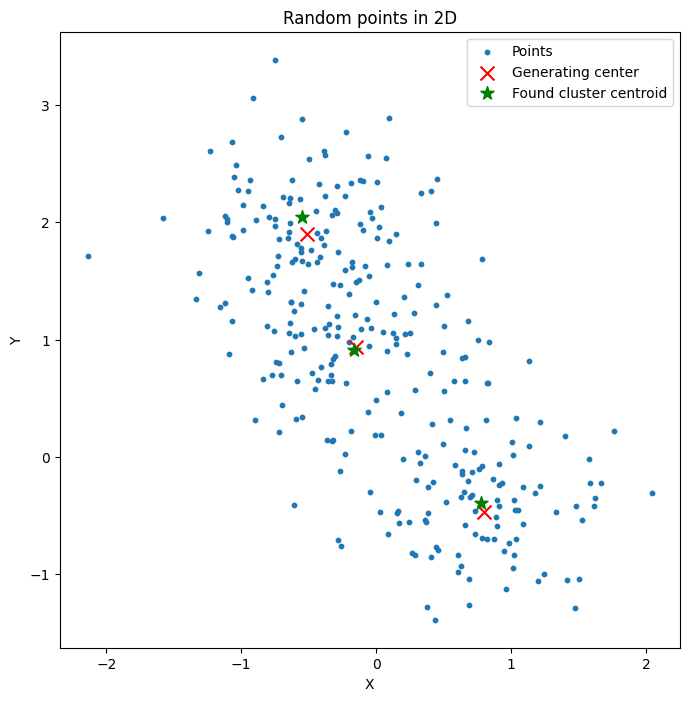

In [5]:
import torch
import matplotlib.pyplot as plt

# Geneating the dataset
num_clusters = 3
num_points_per_cluster = 100
cluster_centers = torch.randn(num_clusters, 2) * 2
X = torch.zeros(num_clusters * num_points_per_cluster, 2)
for i in range(num_clusters):
    cluster_points = torch.randn(num_points_per_cluster, 2) * 0.5 + cluster_centers[i]
    X[i*num_points_per_cluster:(i+1)*num_points_per_cluster] = cluster_points

# Finding the cluster centers using KMeans
kmeans = KMeans()
max_iterations=10
found_centroids, num_iterations = kmeans.find_centroids(X, num_clusters, max_iterations)
print("Found centroids after {} iterations:\n\n{}".format(num_iterations, found_centroids))

# Visualize the generated clusters
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=100, marker='x', c='r')
plt.scatter(found_centroids[:, 0], found_centroids[:, 1], s=100, marker='*', c='g')
plt.title("Random points in 2D")
plt.legend(["Points", "Generating center", "Found cluster centroid"])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Some Basic Statistics

In [6]:
def get_statistics(sample):
    return {
        "mean": sample.mean(),
        "median": sample.median(),
        "mode": sample.mode(),
        "sample_variance": sample.var(),
        "sample_standard_deviation": sample.std(),
    }

sample = torch.tensor([1, 2, 3, 3, 4, 5], dtype=torch.float32)
for key, value in get_statistics(sample).items():
    print("{} is {}\n".format(key, value))

mean is 3.0

median is 3.0

mode is torch.return_types.mode(
values=tensor(3.),
indices=tensor(3))

sample_variance is 2.0

sample_standard_deviation is 1.4142135381698608



# Multinomial Naiive Bayes Classifier

Multinomial Naive Bayes is a variant of the Naive Bayes classifier which is particularly suited for classification tasks where features (predictors) are discrete or can be described by frequencies. For example by the number of occurrences of words in text documents. This makes it very popular for tasks like text classification and spam filtering.

Multinomial Naive Bayes is favored in these scenarios due to its simplicity, efficiency, and often surprisingly good performance, despite the strong independence assumptions it makes.


In [7]:
from collections import defaultdict, Counter
import math

class MultinomialNB:
    def __init__(self, articles_per_tag):
        self.articles_per_tag = articles_per_tag
        self.priors = {}
        self.likelihoods = {}
        self.vocab_size = 0
        self.train()

    def train(self):
        # Initialize counters for words under each tag
        tag_word_counts = defaultdict(Counter)
        tag_counts = Counter()
        total_articles = 0

        # Count occurrences of each word under each tag and total articles per tag
        for tag, articles in self.articles_per_tag.items():
            for article in articles:
                tag_word_counts[tag].update(article)
                tag_counts[tag] += 1
                total_articles += 1

        # Calculate prior probabilities of tags
        self.priors = {tag: math.log(count / total_articles) for tag, count in tag_counts.items()}

        # Calculate likelihoods with Laplacian smoothing
        for tag, words in tag_word_counts.items():
            total_words = sum(words.values())
            self.vocab_size = len(set(word for words in tag_word_counts.values() for word in words))
            self.likelihoods[tag] = {
                word: math.log((count + 1) / (total_words + self.vocab_size + 1))
                for word, count in words.items()
            }
            # Default likelihood for unknown words
            self.likelihoods[tag]["__unknown__"] = math.log(1 / (total_words + self.vocab_size + 1))

    def predict(self, article):
        # Calculate the log probability of the article under each tag
        log_probs = {tag: self.priors[tag] for tag in self.priors}
        for tag in self.priors:
            for word in article:
                if word in self.likelihoods[tag]:
                    log_probs[tag] += self.likelihoods[tag][word]
                else:
                    log_probs[tag] += self.likelihoods[tag]["__unknown__"]

        return log_probs

# Example of how to use this class
articles_per_tag = {
    "politics": [["election", "candidate"], ["vote", "policy"]],
    "sports": [["game", "team"], ["win", "championship"]],
    "tech": [["software", "update"], ["hardware", "release"]]
}
model = MultinomialNB(articles_per_tag)
new_article = ["election", "win", "software"]
print(model.predict(new_article))


{'politics': -8.905105140276813, 'sports': -8.905105140276813, 'tech': -8.905105140276813}
